In [1]:
import numpy as np
import pandas as pd
import os
import numpy as np
from typing import List, Optional, Tuple
from tqdm import tqdm, tqdm_notebook
from torchvision import transforms
from PIL import Image
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch
from sklearn.metrics import f1_score
import random
from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)

### Зафиксируем сид

In [2]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(0)

### Создадим режимы датасета и переключимся на гпу, если возможно

In [3]:
DATA_MODES = ["train", "val", "test"]
RESCALE_SIZE = 224
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

### Создадим списки файлов для трейна и теста

In [4]:
TRAIN_VAL_DIR = "/kaggle/input/journey-springfield/train/simpsons_dataset"
TEST_DIR = "/kaggle/input/journey-springfield/testset/testset"
train_val_files = [os.path.join(dirname.split("/")[-1], filename) \
                   for dirname, _, filenames in os.walk(TRAIN_VAL_DIR) for filename in filenames]
test_files = [filename for dirname, _, filenames in os.walk(TEST_DIR) for filename in filenames]

### Посмотрим на распределение классов

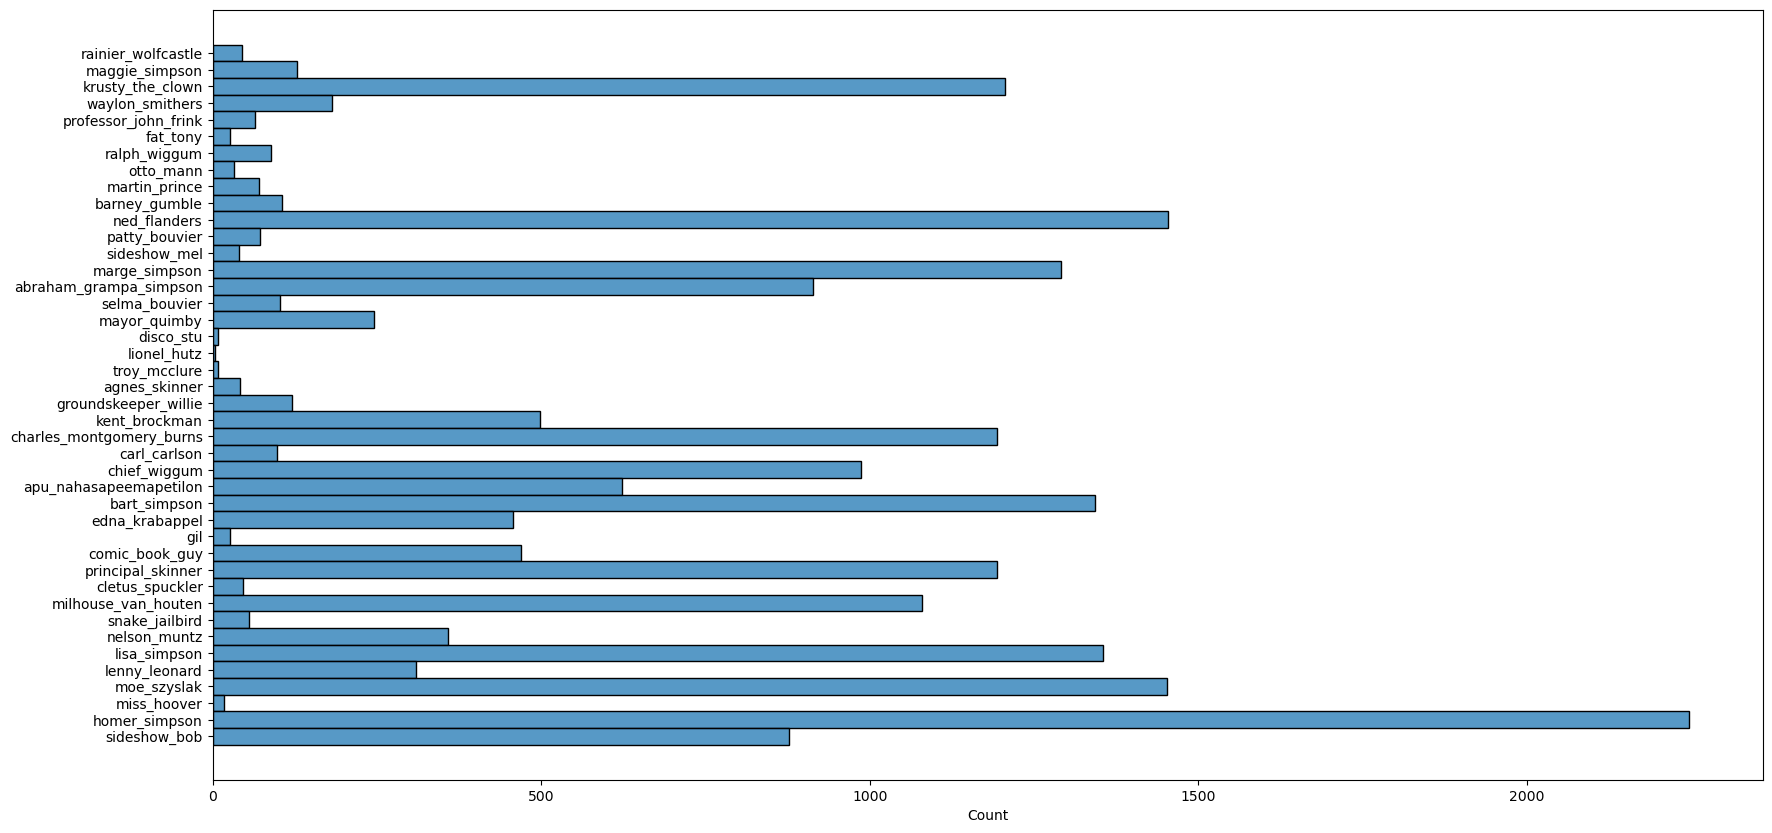

In [5]:
plt.figure(figsize=(20, 10))
train_val_labels = [str(path).split("/")[-2] for path in train_val_files]
n_classes = len(np.unique(train_val_labels))
ax = sns.histplot(y=train_val_labels)

### Разделим выборку

In [6]:
from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(train_val_files,
                                          test_size=0.2,
                                          stratify=train_val_labels)

### С учётом дисбаланса добавим в датасет аугментации малочисленных классов

In [7]:
class SimpsonsDataset(Dataset):
    def __init__(self, 
                 files: List[str],
                 mode: str,
                 *,
                 dirname: Optional[str] = None,
                 encoder: Optional[LabelEncoder] = None
                ) -> None:
        super().__init__()
        self.files = files.copy()
        self.mode = mode
        self.dirname = "" if dirname is None else dirname
        self.len_ = len(self.files)
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError


        if self.mode != "test":
            self.label_encoder = LabelEncoder() if encoder is None else encoder
            self.labels = [path.split("/")[-2] for path in self.files]
            if self.mode == "train":
                small_classes = pd.Series(self.labels).value_counts()[pd.Series(self.labels).value_counts() < 400]
                self.general_img = dict()
                for label in small_classes.index:
                    self.general_img[label] = tuple(pd.Series(self.labels)[pd.Series(self.labels) == label].index)
                aug_images = ["/".join((label, str(i))) for label, cnt in zip(small_classes.index, small_classes) for i in range(400 - cnt)]
                aug_labels = [str(path).split("/")[-2] for path in aug_images]
                self.files.extend(aug_images)
                self.labels.extend(aug_labels)
                self.len_ = len(self.files)
                self.label_encoder.fit(self.labels)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file: str):
        image = Image.open("/".join((self.dirname, file)))
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.files[index][-1] != "g":
            index = self.general_img[self.labels[index]][np.random.randint(len(self.general_img[self.labels[index]]))]
        if self.mode == "train":
            x = self.load_sample(self.files[index])
            x = self._aug_sample(x)
#         else:
#             x = self.load_sample(self.files[index])
#             x = self._prepare_sample(x)
        if self.mode == "test":
            x = self.load_sample(self.files[index])
            x = self._get_sample(x)
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
    
    def _aug_sample(self, image):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ColorJitter(brightness=0.1, contrast=0.2),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(30),
            transforms.RandomCrop(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = np.array(image.resize((256, 256)))
        x = np.array(x / 255, dtype="float32")
        x = transform(x)
        return x

    def _prepare_sample(self, image):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ColorJitter(brightness=0.05, contrast=0.05),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomCrop(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = np.array(image.resize((256, 256)))
        x = np.array(x / 255, dtype="float32")
        x = transform(x)
        return x
    
    def _get_sample(self, image):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = np.array(image.resize((RESCALE_SIZE, RESCALE_SIZE)))
        x = np.array(x / 255, dtype="float32")
        x = transform(x)
        return x
    
    def get_encoder(self) -> LabelEncoder:
        return self.label_encoder

### Cоздадим тренировочный и валидационный датасеты

In [8]:
train_dataset = SimpsonsDataset(
    files=train_files,
    mode='train',
    dirname=TRAIN_VAL_DIR
)
LABEL_ENCODER = train_dataset.get_encoder()
val_dataset = SimpsonsDataset(
    files=val_files,
    mode='val',
    dirname=TRAIN_VAL_DIR,
    encoder=LABEL_ENCODER
)

### Cоздадим функцию для отрисовки и посморим рандомные изображения

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

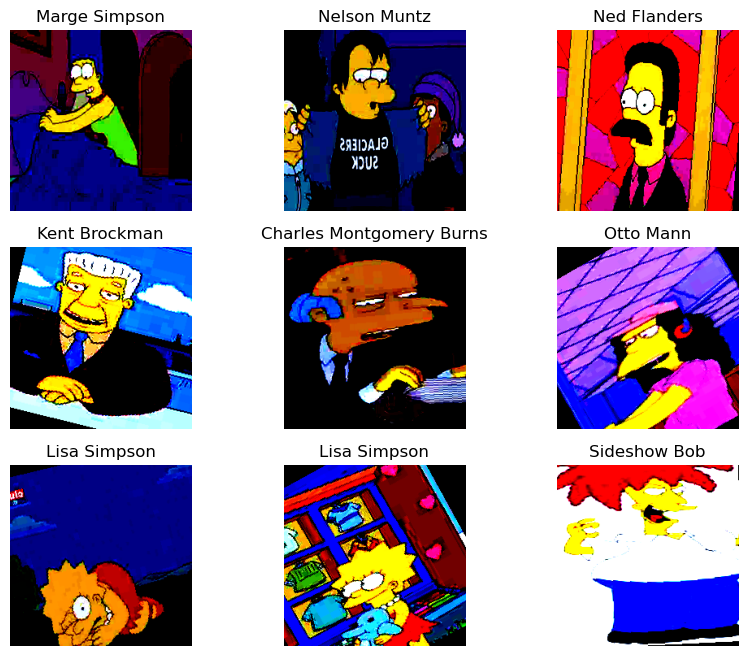

In [10]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    random_number = np.random.randint(len(train_dataset))
    im_val, label = train_dataset[random_number]
    img_label = " ".join(map(lambda x: x.capitalize(), \
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    figure.add_subplot(rows, cols, i)
    plt.title(img_label)
    plt.axis("off")
    plt.imshow(np.transpose(im_val, (1, 2, 0)))
plt.show()

### Немного изменим функции для обучения и предикта

In [11]:
def fit_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.modules.loss._Loss,
    optimizer: torch.optim.Optimizer
) -> Tuple[float, float]:
    running_loss = 0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [12]:
def eval_epoch(
    model: nn.Module,
    val_loader: DataLoader,
    criterion: nn.modules.loss._Loss
) -> Tuple[float, float]:
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [13]:
def train(
    train_dataset: SimpsonsDataset,
    val_dataset: SimpsonsDataset,
    model: nn.Module,
    *,
    epochs: int = 25,
    batch_size: int = 64,
    lr: float = 1e-3,
    step: int = 1
) -> List[Tuple[float, float, float, float]]:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d}\ntrain_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=lr) # , weight_decay=0.01
        criterion = nn.CrossEntropyLoss()
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            opt,     
            T_0 = 8,
            T_mult = 1,
            eta_min = 1e-6
        )
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            torch.save(cnn.state_dict(),
                       f"cnn_{epoch:03d}_{train_loss:0.4f}_{val_loss:0.4f}.pt")
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            if (epoch + 1) % step == 0:
                scheduler.step()
    return history

In [14]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [15]:
def predict_one_sample(
    model: nn.Module,
    inputs: np.ndarray,
    device: torch.device = DEVICE
):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

### Добавим по наитию(инфе из чата) 2 fc слоя и батчнорм

In [16]:
class Cnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(96 * 5 * 5, 560),
            nn.ReLU(),
            nn.BatchNorm1d(560)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(560, 140),
            nn.ReLU()
        )
        self.out = nn.Linear(140, n_classes)
  
  
    def forward(self, x):
        x = self.conv5(self.conv4(self.conv3(self.conv2(self.conv1(x)))))
        x = x.view(x.size(0), -1)
        logits = self.out(self.fc2(self.fc1(x)))
        return logits

### Вот так проходила тренировка, в итоге лучшими оказались модели с 8, 14, 23 и 31 эпохи, их я и сохранил

In [17]:
# cnn = Cnn(n_classes).to(DEVICE)
# history = train(
#     train_dataset,
#     val_dataset,
#     model=cnn,
#     epochs=32,
#     batch_size=64,
#     lr=1e-3,
#     step=1
# )

In [18]:
# loss, acc, val_loss, val_acc = zip(*history)
# plt.figure(figsize=(15, 9))
# plt.plot(loss, label="train_loss")
# plt.plot(val_loss, label="val_loss")
# plt.legend(loc='best')
# plt.xlabel("epochs")
# plt.ylabel("loss")
# plt.show()
# plt.figure(figsize=(15, 9))
# plt.plot(acc, label="train_accuracy")
# plt.plot(val_acc, label="val_accuracy")
# plt.legend(loc='best')
# plt.xlabel("epochs")
# plt.ylabel("loss")
# plt.show()

In [19]:
# y_pred = np.argmax(predict(cnn, [img[0].unsqueeze(0) for img in val_dataset]), -1)
# actual_labels = [x[1] for x in val_dataset]
# f1_score(actual_labels, y_pred, average="weighted")

### Напишем функцию для дообучения

In [20]:
def general_train(
    train_dataset: SimpsonsDataset,
    model: nn.Module,
    *,
    epochs: int = 10,
    batch_size: int = 64,
    lr: float = 1e-3,
    t_0: int = 8,
    lr_min: float = 10e-6
) -> List[Tuple[float, float]]:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    history = []
    log_template = "\nEpoch {ep:03d}\nloss: {t_loss:0.4f} \
    accuracy {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=lr) # , weight_decay=0.01
        criterion = nn.CrossEntropyLoss()
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            opt,
            T_0 = t_0,
            T_mult = 1,
            eta_min = lr_min
        )
        for epoch in range(epochs):
            loss, accuracy = fit_epoch(model, train_loader, criterion, opt)
            history.append((loss, accuracy))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=loss, t_acc=accuracy))
            scheduler.step()
    return history

### Cоздадим датасет из всех размеченных файлов для дообучения

In [21]:
general_train_dataset = SimpsonsDataset(
    files=train_val_files,
    mode='train',
    dirname=TRAIN_VAL_DIR
)
LABEL_ENCODER = general_train_dataset.get_encoder()

### Загрузим сохранённую модель

In [22]:
cnn = Cnn(n_classes).to(DEVICE)
cnn.load_state_dict(torch.load("/kaggle/input/my-pretrained-cnn/cnn_022_0.0272_0.5538.pt", map_location=DEVICE))

<All keys matched successfully>

### Дообучим модель на полном датасете с аугментациями всех изображений

In [23]:
history = general_train(
    train_dataset=general_train_dataset,
    model=cnn,
    epochs=32,
    batch_size=512,
    lr=1e-3,
    t_0=8,
    lr_min=1e-6
)

epoch:   3%|▎         | 1/32 [08:02<4:09:06, 482.16s/it]


Epoch 001
loss: 0.2736     accuracy 0.9271


epoch:   6%|▋         | 2/32 [14:04<3:25:50, 411.68s/it]


Epoch 002
loss: 0.1658     accuracy 0.9555


epoch:   9%|▉         | 3/32 [20:05<3:07:51, 388.68s/it]


Epoch 003
loss: 0.1388     accuracy 0.9618


epoch:  12%|█▎        | 4/32 [26:05<2:55:57, 377.04s/it]


Epoch 004
loss: 0.1141     accuracy 0.9681


epoch:  16%|█▌        | 5/32 [32:05<2:46:56, 370.96s/it]


Epoch 005
loss: 0.1021     accuracy 0.9718


epoch:  19%|█▉        | 6/32 [38:03<2:38:51, 366.59s/it]


Epoch 006
loss: 0.0867     accuracy 0.9767


epoch:  22%|██▏       | 7/32 [44:05<2:32:09, 365.17s/it]


Epoch 007
loss: 0.0782     accuracy 0.9782


epoch:  25%|██▌       | 8/32 [50:05<2:25:27, 363.66s/it]


Epoch 008
loss: 0.0722     accuracy 0.9808


epoch:  28%|██▊       | 9/32 [56:06<2:18:58, 362.53s/it]


Epoch 009
loss: 0.0901     accuracy 0.9742


epoch:  31%|███▏      | 10/32 [1:02:03<2:12:22, 361.01s/it]


Epoch 010
loss: 0.0902     accuracy 0.9748


epoch:  34%|███▍      | 11/32 [1:07:59<2:05:45, 359.29s/it]


Epoch 011
loss: 0.0820     accuracy 0.9766


epoch:  38%|███▊      | 12/32 [1:13:53<1:59:17, 357.87s/it]


Epoch 012
loss: 0.0661     accuracy 0.9807


epoch:  41%|████      | 13/32 [1:19:48<1:53:04, 357.09s/it]


Epoch 013
loss: 0.0570     accuracy 0.9839


epoch:  44%|████▍     | 14/32 [1:25:44<1:46:58, 356.59s/it]


Epoch 014
loss: 0.0498     accuracy 0.9861


epoch:  47%|████▋     | 15/32 [1:31:38<1:40:48, 355.82s/it]


Epoch 015
loss: 0.0420     accuracy 0.9888


epoch:  50%|█████     | 16/32 [1:37:29<1:34:32, 354.54s/it]


Epoch 016
loss: 0.0381     accuracy 0.9893


epoch:  53%|█████▎    | 17/32 [1:43:22<1:28:29, 353.93s/it]


Epoch 017
loss: 0.0570     accuracy 0.9832


epoch:  56%|█████▋    | 18/32 [1:49:16<1:22:33, 353.82s/it]


Epoch 018
loss: 0.0618     accuracy 0.9817


epoch:  59%|█████▉    | 19/32 [1:55:15<1:17:03, 355.64s/it]


Epoch 019
loss: 0.0573     accuracy 0.9830


epoch:  62%|██████▎   | 20/32 [2:01:13<1:11:13, 356.13s/it]


Epoch 020
loss: 0.0460     accuracy 0.9863


epoch:  66%|██████▌   | 21/32 [2:07:08<1:05:13, 355.82s/it]


Epoch 021
loss: 0.0366     accuracy 0.9893


epoch:  69%|██████▉   | 22/32 [2:13:02<59:12, 355.26s/it]


Epoch 022
loss: 0.0342     accuracy 0.9909


epoch:  72%|███████▏  | 23/32 [2:18:54<53:08, 354.33s/it]


Epoch 023
loss: 0.0297     accuracy 0.9920


epoch:  75%|███████▌  | 24/32 [2:24:47<47:10, 353.81s/it]


Epoch 024
loss: 0.0281     accuracy 0.9918


epoch:  78%|███████▊  | 25/32 [2:30:40<41:17, 353.86s/it]


Epoch 025
loss: 0.0392     accuracy 0.9884


epoch:  81%|████████▏ | 26/32 [2:36:34<35:22, 353.79s/it]


Epoch 026
loss: 0.0536     accuracy 0.9836


epoch:  84%|████████▍ | 27/32 [2:42:29<29:29, 353.97s/it]


Epoch 027
loss: 0.0445     accuracy 0.9865


epoch:  88%|████████▊ | 28/32 [2:48:24<23:37, 354.46s/it]


Epoch 028
loss: 0.0382     accuracy 0.9890


epoch:  91%|█████████ | 29/32 [2:54:20<17:45, 355.03s/it]


Epoch 029
loss: 0.0293     accuracy 0.9910


epoch:  94%|█████████▍| 30/32 [3:00:18<11:51, 355.86s/it]


Epoch 030
loss: 0.0252     accuracy 0.9932


epoch:  97%|█████████▋| 31/32 [3:06:17<05:56, 356.66s/it]


Epoch 031
loss: 0.0213     accuracy 0.9939


epoch: 100%|██████████| 32/32 [3:12:09<00:00, 360.31s/it]


Epoch 032
loss: 0.0203     accuracy 0.9946


### Cоздадим тестовый датасет и сделаем предикты

In [24]:
test_dataset = SimpsonsDataset(
    files=sorted(test_files, key=lambda x: int(x[3:-4])),
    mode='test',
    dirname=TEST_DIR
)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
pred = LABEL_ENCODER.inverse_transform(np.argmax(predict(cnn, test_loader), axis=1))

### Cохраним в csv и получим f1-score 0.99893
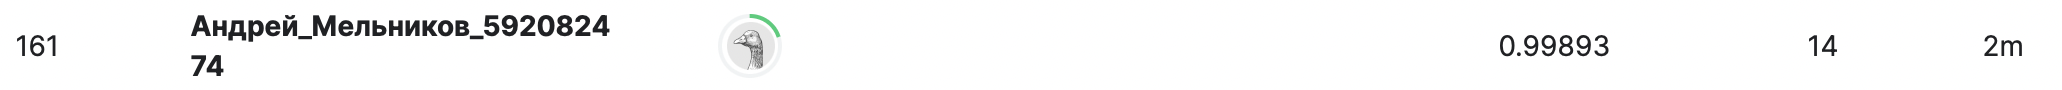

In [25]:
sub = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")
sub["Expected"] = pred
sub.to_csv("submission.csv", index=False)

In [26]:
# sub = pd.read_csv("/kaggle/input/my-submission6/submission-6.csv")
# sub.to_csv("submission.csv", index=False)